---
title: "From clouds to code: mapping big climate data with Python"
title-block-banner: true
description: "An open-source Python workflow for accessing, processing, and mapping large-scale historical and projected climate model data"
author: 
  - name: Maxwell Pepperdine
    url: https://maxpepperdine.github.io
    affiliation: MESM
    affiliation_url: https://bren.ucsb.edu/masters-programs/master-environmental-science-and-management 
date: 2025-05-11
categories: [Geospatial-analysis, Python, MESM]
toc: true
image: air_temp.jpg
code-fold: true
code-summary: "Show code"
citation: 
  url: https://maxpepperdine.github.io/posts/2025-05-11-mapping-big-climate-data/
draft: false
---

# Analyzing Historical and Future Climate Data in Southern Africa 

*A workflow adapted from the [Climate DataLab](https://github.com/climate-datalab) as part of EDS 296-1S (Advanced Special Topics in Environmental Data Science: A Climate Modeling Perspective on Big Data Techniques), a course offered at the Bren School of Environmental Science & Management.*

## **Overview**

This post walks through the process of accessing, processing, and visualizing large-scale climate data from Amazon Web Services (AWS) using `Python` in a `Jupyter Lab` environment. Focusing on Southern Africa, the analysis draws on two global climate models — `GFDL-ESM4` and `IPSL-CM6A-LR` — to download and map historical simulations and future projections of air temperature. The workflow highlights geospatial data manipulation with `xarray`, `rioxarray`, and `geopandas`, including time averaging, model comparison, and visualization using `matplotlib` and `cartopy`. This post provides a practical introduction to open-source tools for regional climate analysis with cloud-hosted datasets.

In [1]:
# load packages
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
from cftime import DatetimeNoLeap

## **(1) Climate Data Description**

Using the CMIP6 database hosted on Amazon Web Services, we will be downloading/using both historical simulations and future projections from two climate models (`GFDL-ESM4` and `IPSL-CM6A-LR`) for `ssp370`. 

**Climate Models:** <br> `GFDL-ESM4` is the Geophysical Fluid Dynamics Laboratory (GFDL) Earth System Model version 4 (ESM4) climate model. It's a coupled chemistry-carbon-climate Earth system model that was developed at the GFDL. As described by [NOAA](https://www.gfdl.noaa.gov/earth-system-esm4/), `GFDL-ESM4` consists of:

- atmosphere at approximately 1 degree resolution with 49 levels of comprehensive, interactive chemistry and aerosols (including aerosol indirect effect) from precursor emissions
- OM4 MOM6-based ocean at ½ degree resolution with 75 levels using hybrid pressure/isopycnal vertical coordinate
- SIS2 sea ice with radiative transfer and C-grid dynamics for compatibility with MOM6
- LM4.1 land model with a new vegetation dynamics model with explicit treatment of plant age and height structure and soil microbes, with daily fire, crops, pasture, and grazing tiles
- COBALTv2 ocean biogeochemical component representing ocean ecological and biogeochemical interactions
- Fully Interactive dust and iron cycling between land-atmosphere and ocean

`IPSL-CM6A-LR` is the latest version of the Institut Pierre Simon Laplace (IPSL) climate model. It's a physical atmosphere-land-ocean-sea ice model that also includes a representation of the carbon cycle, and it was developed at the IPSL to study natural climate variability and climate response to both anthropogenic and natural changes as part of CMIP6.

**SSP Scenario:** <br> `ssp370` (also written as `SSP3-RCP7.0`) refers to the Shared Socioeconomic Pathway 3 combined with a radiative forcing level of 7.0 W/m² by the year 2100. It is considered a medium-to-high emissions scenario and commonly known as the "Regional Rivalry" pathway, characterized by high challenges to both mitigation and adaptation. A [Carbon Brief](https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/) article written by Zeke Hausfather describes SSP3 as the following:

- *"A resurgent nationalism, concerns about competitiveness and security, and regional conflicts push countries to increasingly focus on domestic or, at most, regional issues. Policies shift over time to become increasingly oriented toward national and regional security issues. Countries focus on achieving energy and food security goals within their own regions at the expense of broader-based development. Investments in education and technological development decline. Economic development is slow, consumption is material-intensive, and inequalities persist or worsen over time. Population growth is low in industrialized and high in developing countries. A low international priority for addressing environmental concerns leads to strong environmental degradation in some regions."*
 

## **(2) Climate Data Download & Acquisition**

We'll be downloading surface air temperature (`tas`) data from the following two climate models:

- `GFDL-ESM4`
- `IPSL-CM6A-LR`

For each climate model, we need:

- Historical simulations
- Future projections for `ssp370`

**Characteristics of these files** (corresponding fields in the CMIP6 catalog are in parentheses):

- _Variable ("variable_id")_: This is a surface air temperature, or "tas", variable.
- _Realm ("table_id")_: Surface air temperature is generated by the atmosphere component of a climate model ("A"), and the information in this particular file is averaged monthly ("mon").
- _Model ("source_id")_: The name of the climate model
- _Experiment ("experiment_id")_: The name of the model experiment being run. The file above is a _historical_ simulation: since we're also interested in the future projection information, we'll further specify that we'd also like the associated SSP below.
- _Ensemble member ("member_id")_: The name of this ensemble member is "r1i1p1f1".

The workflow used to download the data was guided by the [Accessing CMIP6 Data via AWS](https://github.com/climate-datalab/CMIP6_AWS) tutorial.

In [2]:
# Open the CMIP6 data catalog, store as a variable
CMIP6_catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

#### Climate model #1: **GFDL-ESM4**

In [3]:
# Specify search terms to query catalog for GFDL-ESM4 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP']

# source_id: which model do you want? 
source_id = ['GFDL-ESM4']

# experiment_id: what experimental configuration do you want? Here we want historical and ssp370
experiment_ids = ['historical', 'ssp370']

# member_id: which ensemble member do you want? Here we want r1i1p1f1
member_id = 'r1i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon'

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas'

In [4]:
# Search through catalog, store results in "res" variable
res_gfdl = CMIP6_catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res_gfdl.df)

# Extract data for the historical period, store as a separate xarray Dataset
hist_data_gfdl = xr.open_zarr(res_gfdl.df['zstore'][1], storage_options={'anon': True})

# Extract data for each SSP 
future_data_ssp370_gfdl = xr.open_zarr(res_gfdl.df['zstore'][0], storage_options={'anon': True})

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


#### Climate model #2: **IPSL-CM6A-LR**

In [5]:
# Specify search terms to query catalog for IPSL-CM6A data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP']

# source_id: which model do you want? 
source_id = ['IPSL-CM6A-LR']

# experiment_id: what experimental configuration do you want? Here we want historical and ssp370
experiment_ids = ['historical', 'ssp370']

# member_id: which ensemble member do you want? Here we want r1i1p1f1
member_id = 'r1i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon'

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas'

In [6]:
# Search through catalog, store results in "res" variable
res_ipsl = CMIP6_catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res_ipsl.df)

# Extract data for the historical period, store as a separate xarray Dataset
hist_data_ipsl = xr.open_zarr(res_ipsl.df['zstore'][0], storage_options={'anon': True})

# Extract data for each SSP 
future_data_ssp370_ipsl = xr.open_zarr(res_ipsl.df['zstore'][1], storage_options={'anon': True})

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,s3://cmip6-pds/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/hi...,NaN,20180803
1,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r1i1p1f1,Amon,tas,gr,s3://cmip6-pds/CMIP6/ScenarioMIP/IPSL/IPSL-CM6...,NaN,20190119


## **(3) Focus Region -- Southern Africa**

The focus region for this analysis is Southern Africa. As it sounds, it's the southernmost region of Africa. There are various definitions for the exact extent of this region, but we'll be using the delineation of the [United Nations geoscheme](https://en.wikipedia.org/wiki/United_Nations_geoscheme) that includes Botswana, Eswatini, Lesotho, Namibia, and South Africa. 

**Southern Africa Climate:** <br>
Due to its size and varied geography, the greater Southern Africa region exhibits a wide range of climates. In general, this area is characterized by a subtropical to temperate climate, with significant variations in temperature and rainfall throughout the year. The northwest reaches of Southern Africa (namely western Namibia) exhibit desert conditions, the eastern coast can be classified as more subtropical, and the southwest (coastal reaches of South Africa) experience a Mediterranean climate. As mentioned above, average mean surface air temperature and precipitation vary significanly both throughout the region and annually. Southern areas throughout South Africa are cooler than the northern locations in Namibia and Botswana, with average mean surface air temperatures around 17 - 19 deg C and 22 - 24 deg C, respectively. Annually, temperatures fluctuate significantly with Nov - Mar being the hottest, and Apr - Oct the coldest. Southern areas of Southern Africa recieve less mean annual rainfall than northern areas of this region, and similarly to temperature trends, annual precipitation varies significantly with the vast majority of rainfall occuring in the wet season months (Nov - March), and little to no rainfall during the dry season (Apr - Oct). 

**Climate Change Impacts:** <br>
In a region that already experiences drastic fluctuations in temperature and precipitation throughout each year, I might expect these patterns to become even more pronounced under a changing climate. I would expect overall rainfall to decrease, with an increase in extreme precipitation events like atmospheric rivers. This would likely result in more frequent drying of river and stream networks, with and more frequent flooding events. Following global trends, I would expect average temperatures to also increase throughout the greater Southern Africa Region. 

**A reasonable lat/lon bounds for the Southern Africa Region is:**

- Latitude range of 38°S to 15°S
- Longitude range of 10°E to 38°E

*Information on Southern Africa's climate was sourced from the [Climate Change Knowledge Portal](https://climateknowledgeportal.worldbank.org/).*

## **(4) Focus on Specific Time Periods & Make Maps**

This analysis focuses on the following two time periods:

- **2000-2050**
- **2050-2100**

I chose these time periods to get a sense of climatic trends in a recent to mid century window, and mid to late century window to acquire a full picture of temperature trends in the Southern Africa region throughout this century. 

### **Data Processing**

First, we'll concatenate the historical and SSP information into a single `xarray` object to make the plotting simpler:

In [7]:
# GFDL-ESM4 data
gfdl_data_ssp370 = xr.concat([hist_data_gfdl, future_data_ssp370_gfdl], dim="time")

# IPSL-CM6A-LR data 
ipsl_data_ssp370 = xr.concat([hist_data_ipsl, future_data_ssp370_ipsl], dim="time")

In [8]:
# examine the time format for both datasets 
#print(gfdl_data_ssp370.time)
#print(ipsl_data_ssp370.time)

It looks like the IPSL model data is already in a `dtype` of `datetime64`; however, we'll need to change the format of the GFDL data to `datetime64` to make plotting easier with `Matplotlib`

In [9]:
# convert the time variable to datetime format in the GFDL data
time = gfdl_data_ssp370.time.astype('datetime64[ns]')
#print(time)

#### Define the Time Periods We're Mapping

First, we need to examine the time formats of each climate model.

In [10]:
print(type(gfdl_data_ssp370.time.values[0]))

<class 'cftime._cftime.DatetimeNoLeap'>


In [11]:
print(type(ipsl_data_ssp370.time.values[0]))

<class 'numpy.datetime64'>


`gfdl_data_ssp370` uses `cftime.DatetimeNoLeap`, which requires using that same calendar class. So, we need to use a different start and end date format that's compatible for selecting specific time periods out of this object. The `ipsl_data_ssp370` time coordinate uses standard `numpy.datetime64`, so we can slice it with normal strings like "2000-01-01" and don't need `cftime`.

In [12]:
# Extract an xarray DataArray containing the tas variable
gfdl_data_ssp370 = gfdl_data_ssp370.tas
ipsl_data_ssp370 = ipsl_data_ssp370.tas

# convert units from Kelvin to Celsius
gfdl_data_ssp370 = gfdl_data_ssp370 - 273.15
ipsl_data_ssp370 = ipsl_data_ssp370 - 273.15

#### Select the time periods for the `GFDL` data

In [13]:
# define the first time period
start_date1 = DatetimeNoLeap(2000, 1, 1)
end_date1 = DatetimeNoLeap(2050, 12, 31)

# define the second time period 
start_date2 = DatetimeNoLeap(2050, 1, 1)
end_date2 = DatetimeNoLeap(2100, 12, 31)


# extract data for 2000-2050
temp_data_slice_gfdl_2000 = gfdl_data_ssp370.sel(
    time=(gfdl_data_ssp370.time >= start_date1) & 
         (gfdl_data_ssp370.time <= end_date1)
)

# extract data for 2050-2100
temp_data_slice_gfdl_2050 = gfdl_data_ssp370.sel(
    time=(gfdl_data_ssp370.time >= start_date2) & 
         (gfdl_data_ssp370.time <= end_date2)
)

#### Select the time periods for the `IPSL` data

In [14]:
# extract data for 2000-2050
temp_data_slice_ipsl_2000 = ipsl_data_ssp370.sel(
    time=slice("2000-01-01", "2050-12-31")
)

# extract data for 2050-2100
temp_data_slice_ipsl_2050 = ipsl_data_ssp370.sel(
    time=slice("2050-01-01", "2100-12-31")
)

### **Map the Mean Average Over Each Time Period**

Take the time average of our filtered data for each climate model, and plot it for our specific region of interest (Southern Africa). 

In [15]:
# Time average GFDL
temp_data_mn_gfdl_2000 = temp_data_slice_gfdl_2000.mean(dim=["time"])
temp_data_mn_gfdl_2050 = temp_data_slice_gfdl_2050.mean(dim=["time"])

# Time average IPSL
temp_data_mn_ipsl_2000 = temp_data_slice_ipsl_2000.mean(dim=["time"])
temp_data_mn_ipsl_2050 = temp_data_slice_ipsl_2050.mean(dim=["time"])

#### **2000-2050 & 2050-2100**, `GFDL-ESM4`

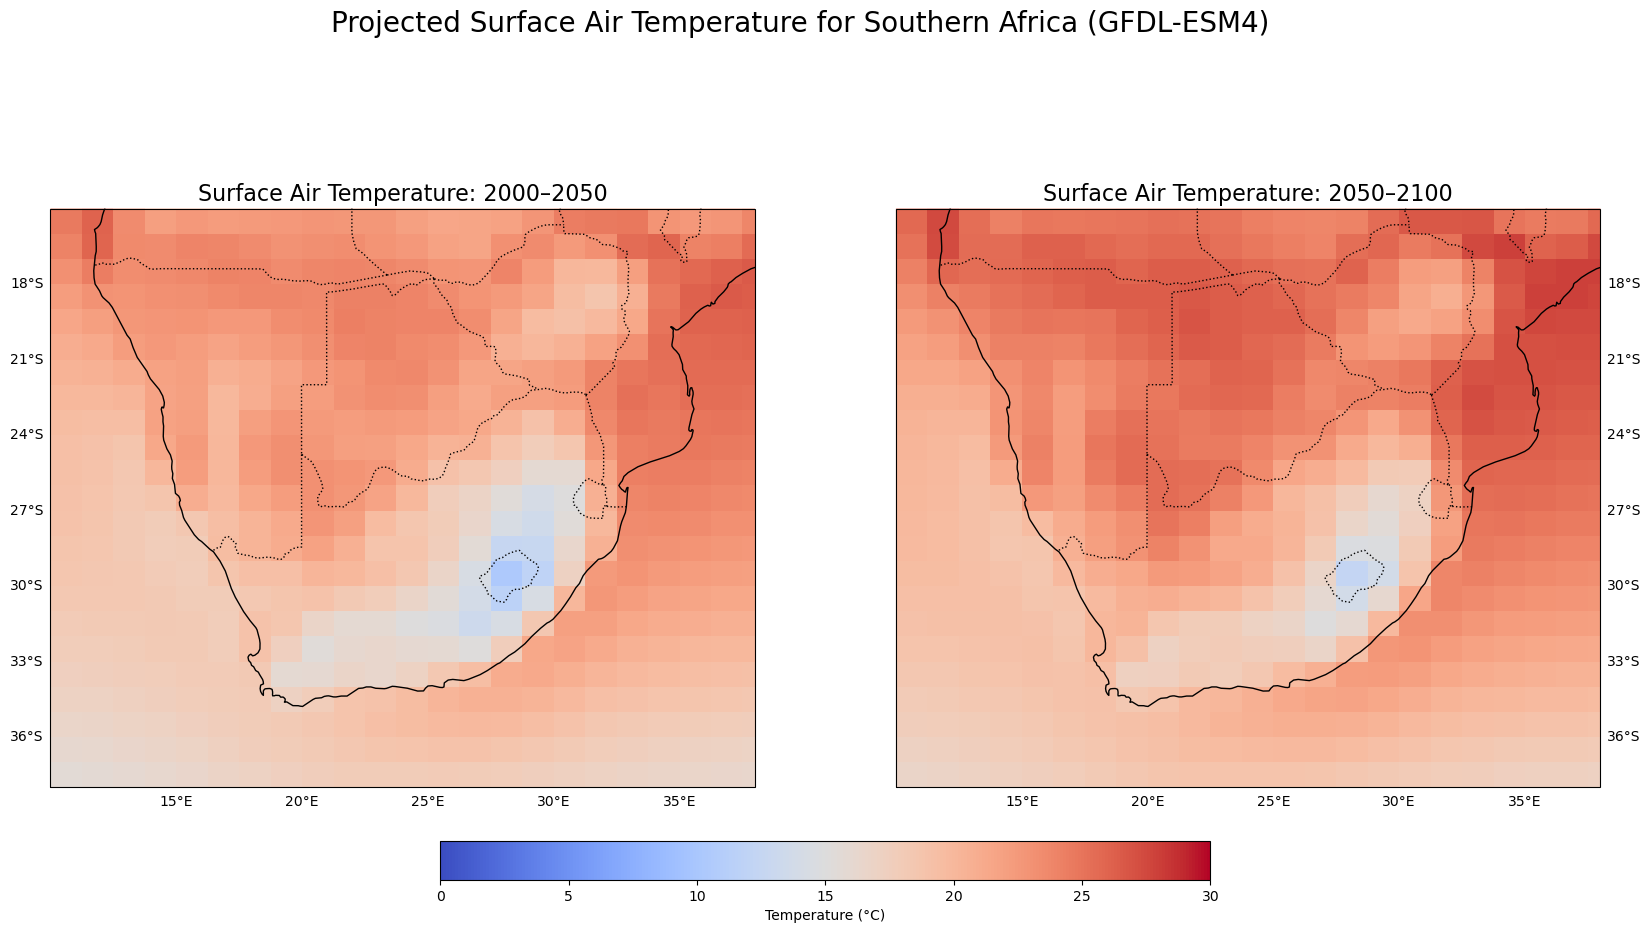

In [16]:
# Define PlateCarree projection
map_proj = ccrs.PlateCarree()

# Create figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10),
                         subplot_kw={"projection": map_proj})

# Shared settings
extent = [10, 38, -38, -15]

# Plot for 2000-2050
plot1 = axes[0].pcolormesh(
    temp_data_mn_gfdl_2000.lon, temp_data_mn_gfdl_2000.lat,
    temp_data_mn_gfdl_2000, transform=map_proj, cmap="coolwarm", vmin=0, vmax=30
)
axes[0].set_extent(extent, crs=map_proj)
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.BORDERS, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
axes[0].set_title("Surface Air Temperature: 2000–2050", fontsize=16)

# Hide gridlines (make the lines transparent)
gl1.xlines = False
gl1.ylines = False

# Plot for 2050-2100
plot2 = axes[1].pcolormesh(
    temp_data_mn_gfdl_2050.lon, temp_data_mn_gfdl_2050.lat,
    temp_data_mn_gfdl_2050, transform=map_proj, cmap="coolwarm", vmin=0, vmax=30
)
axes[1].set_extent(extent, crs=map_proj)
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.BORDERS, linestyle=":")
gl2 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl2.top_labels = False
gl2.left_labels = False
axes[1].set_title("Surface Air Temperature: 2050–2100", fontsize=16)

# Hide gridlines (make the lines transparent)
gl2.xlines = False
gl2.ylines = False

# Add shared colorbar
cbar = fig.colorbar(plot2, ax=axes[:], orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("Temperature (°C)")

# Add main title
fig.suptitle("Projected Surface Air Temperature for Southern Africa (GFDL-ESM4)", fontsize=20)

plt.show()

#### **2000-2050 & 2050-2100**, `IPSL-CM6A-LR`

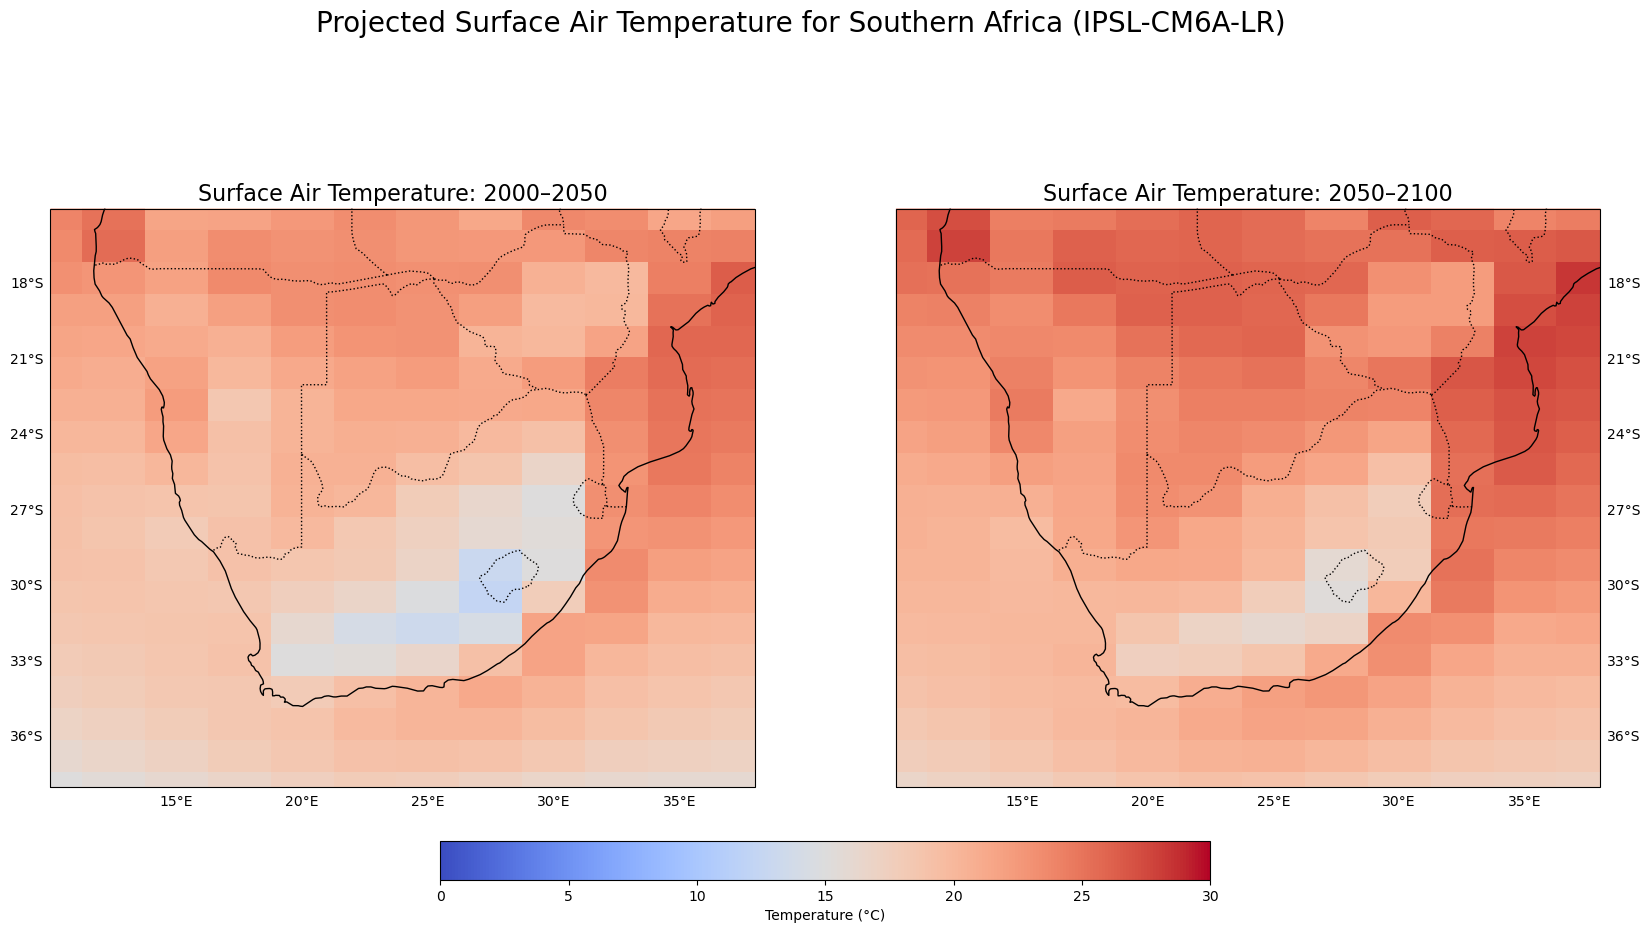

In [17]:
# Define PlateCarree projection
map_proj = ccrs.PlateCarree()

# Create figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10),
                         subplot_kw={"projection": map_proj})

# Shared settings
extent = [10, 38, -38, -15]

# Plot for 2000-2050
plot1 = axes[0].pcolormesh(
    temp_data_mn_ipsl_2000.lon, temp_data_mn_ipsl_2000.lat,
    temp_data_mn_ipsl_2000, transform=map_proj, cmap="coolwarm", vmin=0, vmax=30
)
axes[0].set_extent(extent, crs=map_proj)
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.BORDERS, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
axes[0].set_title("Surface Air Temperature: 2000–2050", fontsize=16)

# Hide gridlines (make the lines transparent)
gl1.xlines = False
gl1.ylines = False

# Plot for 2050-2100
plot2 = axes[1].pcolormesh(
    temp_data_mn_ipsl_2050.lon, temp_data_mn_ipsl_2050.lat,
    temp_data_mn_ipsl_2050, transform=map_proj, cmap="coolwarm", vmin=0, vmax=30
)
axes[1].set_extent(extent, crs=map_proj)
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.BORDERS, linestyle=":")
gl2 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl2.top_labels = False
gl2.left_labels = False
axes[1].set_title("Surface Air Temperature: 2050–2100", fontsize=16)

# Hide gridlines (make the lines transparent)
gl2.xlines = False
gl2.ylines = False

# Add shared colorbar
cbar = fig.colorbar(plot2, ax=axes[:], orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("Temperature (°C)")

# Add main title
fig.suptitle("Projected Surface Air Temperature for Southern Africa (IPSL-CM6A-LR)", fontsize=20)

plt.show()

### **Map the Difference in the Averages Between the Two Time Periods**

Take the difference between each time period. 

In [18]:
# subtract the mid century tas data from the late century tas data
gfdl_tas_diff = temp_data_mn_gfdl_2050 - temp_data_mn_gfdl_2000 
ipsl_tas_diff = temp_data_mn_ipsl_2050 - temp_data_mn_ipsl_2000 

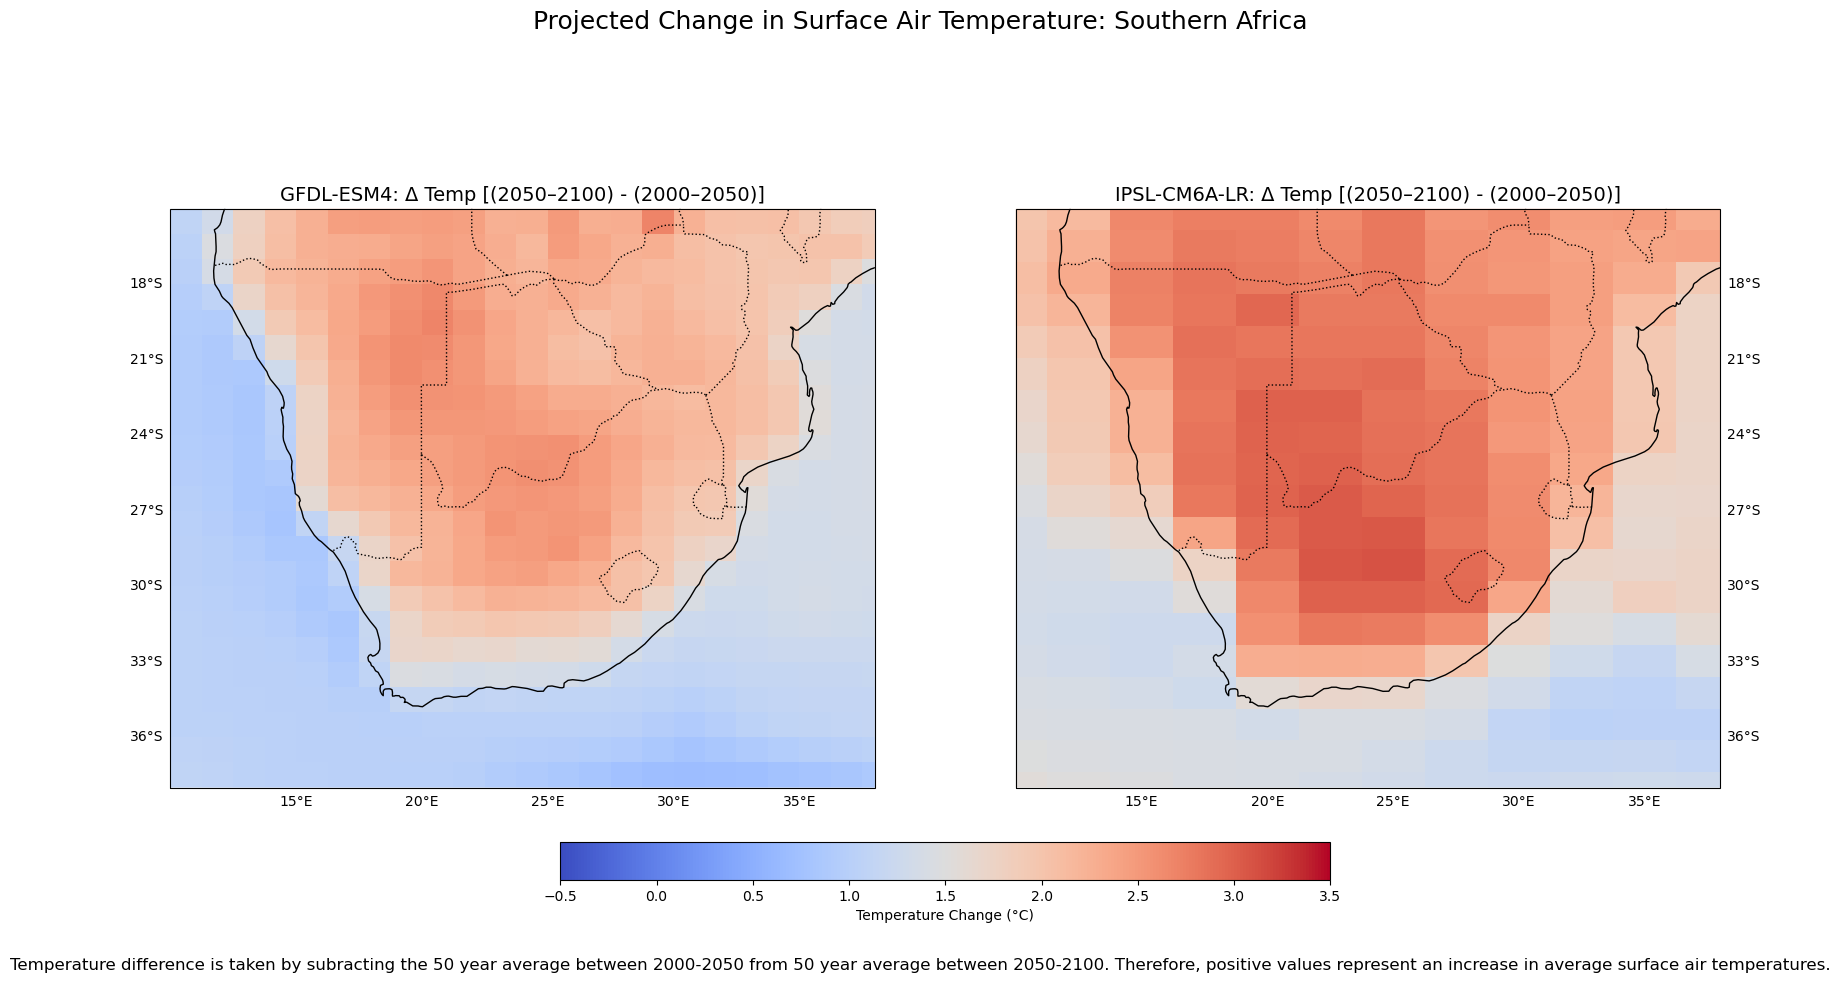

In [19]:
# Define PlateCarree projection
map_proj = ccrs.PlateCarree()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(ncols=2, figsize=(20, 10), 
                         subplot_kw={'projection': map_proj})

# Set common extent for both subplots (Southern Africa)
extent = [10, 38, -38, -15]

# --- Plot 1: GFDL-ESM4 ---
p1 = axes[0].pcolormesh(
    gfdl_tas_diff.lon, gfdl_tas_diff.lat, gfdl_tas_diff,
    transform=map_proj, cmap="coolwarm", vmin=-0.5, vmax=3.5
)
axes[0].set_extent(extent, crs=map_proj)
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.BORDERS, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlines = False
gl1.ylines = False
axes[0].set_title("GFDL-ESM4: Δ Temp [(2050–2100) - (2000–2050)]", fontsize=14)

# --- Plot 2: IPSL-CM6A-LR ---
p2 = axes[1].pcolormesh(
    ipsl_tas_diff.lon, ipsl_tas_diff.lat, ipsl_tas_diff,
    transform=map_proj, cmap="coolwarm", vmin=-0.5, vmax=3.5
)
axes[1].set_extent(extent, crs=map_proj)
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.BORDERS, linestyle=":")
gl2 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl2.top_labels = False
gl2.left_labels = False
gl2.xlines = False
gl2.ylines = False
axes[1].set_title("IPSL-CM6A-LR: Δ Temp [(2050–2100) - (2000–2050)]", fontsize=14)

# Add shared colorbar below the plots
cbar = fig.colorbar(p2, ax=axes[:], orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("Temperature Change (°C)")

# Add main title
fig.suptitle("Projected Change in Surface Air Temperature: Southern Africa", fontsize=18)

# Add a caption
fig.text(0.5, 0.02, 
         "Temperature difference is taken by subracting the 50 year average between 2000-2050 from 50 year average between 2050-2100. Therefore, positive values represent an increase in average surface air temperatures.", 
         ha='center', fontsize=12)

plt.show()

## **(5) Reflection**

**Results:** <br> Looking at the first sets of plots that show the projected average surface air temperature in Southern Africa between time periods of 2000-2050 and 2050-2100, it's evident that temperatures are projected to increase moving into the late century. This trend becomes more apparent when taking the difference between the average temperatures of each time period. We subtracted the earlier period from the later period; therefore, positive values represent an increase in projected average temperatures, and negative values represent a decrease. Looking at our difference plots above for each climate model, there's a clear trend of increasing projected air temperatures. The `IPSL-CM6A-LR` climate model projects a more significant increase than the `GFDL-ESM4` model. 

**Implications:** <br> Rising average surface air temperatures across the greater Southern Africa region are likely to have widespread and compounding effects on both human populations and ecosystems. Higher temperatures can lead to increased evaporation rates and soil moisture loss, further stressing agricultural systems already vulnerable to climate variability. Crop failures may become more frequent, and livestock health may deteriorate as heat stress intensifies. Ecosystems throughout the region will also face mounting pressure, with species being forced to adapt, migrate, or face possible decline as thermal thresholds are exceeded. For human populations, prolonged exposure to extreme heat may worsen health outcomes, particularly for those with limited access to cooling infrastructure or healthcare. In urban areas, the intensification of the urban heat island effect could exacerbate social inequalities, while in rural areas, higher temperatures may further strain already limited water and food resources.

## **(6) Acknowledgements**

This assignment was created and organized by Sam Stevenson-Karl, an Associate Professor at the Bren School and the instructor for EDS 296-1S. EDS 296-1S (Advanced Special Topics in Environmental Data Science: A Climate Modeling Perspective on Big Data Techniques) is offered in the [Master of Environmental Data Science (MEDS)](https://bren.ucsb.edu/masters-programs/master-environmental-data-science) program at the Bren School.

The workflow used to complete this analysis was adapted from the [Climate DataLab](https://github.com/climate-datalab), an open source resource for climate model education that's supported by a growing community of educators, scientists, and developers working together to make climate data science more inclusive and effective.